# Training with Back-propagation Algorithms

Back-propagation (BP) trainings have become foundations in machine learning algorithms. In this section, we are going to talk about how to train models with BP.

In [18]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd
import numpy as np

bm.set_platform('cpu')

bp.__version__

'2.3.0'

Here, we train two kinds of models to classify MNIST dataset. The first is ANN models commonly used in deep neural networks. The second is SNN models.

## Train a ANN model

We first build a three layer ANN model:

```bash

i >> r >> o
```

where the recurrent layer ``r`` is a LSTM cell, the output ``o`` is a linear readout.

In [19]:
class ANNModel(bp.dyn.DynamicalSystem):
    def __init__(self, num_in, num_rec, num_out):
        super(ANNModel, self).__init__()
        self.rec = bp.layers.LSTMCell(num_in, num_rec)
        self.out = bp.layers.Dense(num_rec, num_out)

    def update(self, sha, x):
        x = self.rec(sha, x)
        x = self.out(sha, x)
        return x

Before training this model, we get and clean the data we want.

In [20]:
root = r"D:\data"
train_dataset = bd.vision.FashionMNIST(root, split='train', download=True)
test_dataset = bd.vision.FashionMNIST(root, split='test', download=True)



def get_data(dataset, batch_size=256):
    def data_generator():
        X = bm.array(dataset.data, dtype=bm.dftype()) / 255
        Y = bm.array(dataset.targets, dtype=bm.ditype())
        key = bm.random.DEFAULT.split_key()
        X = bm.random.permutation(X, key=key)
        Y = bm.random.permutation(Y, key=key)
        for i in range(0, len(dataset), batch_size):
            yield X[i: i+batch_size], Y[i: i+batch_size]

    return data_generator


Then, we start to train our defined ANN model with ``brainpy.train.BPTT`` training interface.

In [21]:
# model
model = ANNModel(28, 100, 10)

# loss function
def loss_fun(predicts, targets):
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(axis=-1) == targets)
    return loss, {'acc': acc}

# optimizer
optimizer=bp.optim.Adam(lr=1e-3)

# trainer
trainer = bp.train.BPTT(model,
                        loss_fun=loss_fun,
                        loss_has_aux=True,
                        optimizer=optimizer)

In [22]:
trainer.fit(train_data=get_data(train_dataset, 256),
            test_data=get_data(test_dataset, 512),
            num_epoch=10)

Train 0 epoch, use 12.1708 s, loss 0.8835940361022949, acc 0.6864361763000488
Test 0 epoch, use 0.6309 s, loss 0.6134902238845825, acc 0.7796070575714111
Train 1 epoch, use 10.7388 s, loss 0.5161257386207581, acc 0.8127105236053467
Test 1 epoch, use 0.3487 s, loss 0.5257689356803894, acc 0.8067669868469238
Train 2 epoch, use 10.8155 s, loss 0.44644325971603394, acc 0.8382037281990051
Test 2 epoch, use 0.3294 s, loss 0.45477432012557983, acc 0.8393669128417969
Train 3 epoch, use 10.7835 s, loss 0.41742411255836487, acc 0.8480052947998047
Test 3 epoch, use 0.3315 s, loss 0.42174917459487915, acc 0.8474035263061523
Train 4 epoch, use 10.8599 s, loss 0.3883253335952759, acc 0.8581339120864868
Test 4 epoch, use 0.3293 s, loss 0.41360148787498474, acc 0.8485294580459595
Train 5 epoch, use 10.7547 s, loss 0.3702569901943207, acc 0.8637134432792664
Test 5 epoch, use 0.3302 s, loss 0.4075957238674164, acc 0.8480181694030762
Train 6 epoch, use 10.8626 s, loss 0.355184406042099, acc 0.87036794424

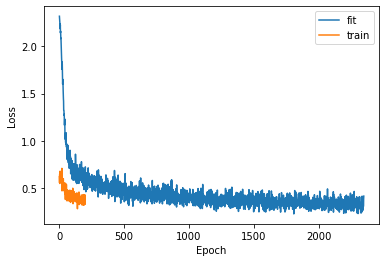

In [23]:
import matplotlib.pyplot as plt

plt.plot(trainer.get_hist_metric('fit'), label='fit')
plt.plot(trainer.get_hist_metric('test'), label='train')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Train a SNN model

Similarly, ``brainpy.train.BPTT`` can also be used to train SNN models.

We first build a three layer SNN model:

```bash

i >> [exponential synapse] >> r >> [exponential synapse] >> o
```

In [24]:
class SNNModel(bp.dyn.DynamicalSystem):
  def __init__(self, num_in, num_rec, num_out):
    super(SNNModel, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out

    # neuron groups
    self.i = bp.neurons.InputGroup(num_in, mode=bp.modes.training)
    self.r = bp.neurons.LIF(num_rec, tau=10, V_reset=0, V_rest=0, V_th=1.,
                            mode=bp.modes.training)
    self.o = bp.neurons.LeakyIntegrator(num_out, tau=5, mode=bp.modes.training)

    # synapse: i->r
    self.i2r = bp.synapses.Exponential(self.i, self.r, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(), tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.),
                                       mode=bp.modes.training)
    # synapse: r->o
    self.r2o = bp.synapses.Exponential(self.r, self.o, bp.conn.All2All(),
                                       output=bp.synouts.CUBA(), tau=10.,
                                       g_max=bp.init.KaimingNormal(scale=2.),
                                       mode=bp.modes.training)

  def update(self, shared, spike):
    self.i2r(shared, spike)
    self.r2o(shared)
    self.r(shared)
    self.o(shared)
    return self.o.V.value

As the model receives spiking inputs, we define functions that are necessary to transform the continuous values to spiking data.

In [25]:
def current2firing_time(x, tau=20., thr=0.2, tmax=1.0, epsilon=1e-7):
  x = np.clip(x, thr + epsilon, 1e9)
  T = tau * np.log(x / (x - thr))
  T = np.where(x < thr, tmax, T)
  return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
  labels_ = np.array(y, dtype=bm.ditype())
  sample_index = np.arange(len(X))

  # compute discrete firing times
  tau_eff = 2. / bm.get_dt()
  unit_numbers = np.arange(nb_units)
  firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=bm.ditype())

  if shuffle:
    np.random.shuffle(sample_index)

  counter = 0
  number_of_batches = len(X) // batch_size
  while counter < number_of_batches:
    batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
    all_batch, all_times, all_units = [], [], []
    for bc, idx in enumerate(batch_index):
      c = firing_times[idx] < nb_steps
      times, units = firing_times[idx][c], unit_numbers[c]
      batch = bc * np.ones(len(times), dtype=bm.ditype())
      all_batch.append(batch)
      all_times.append(times)
      all_units.append(units)
    all_batch = np.concatenate(all_batch).flatten()
    all_times = np.concatenate(all_times).flatten()
    all_units = np.concatenate(all_units).flatten()
    x_batch = bm.zeros((batch_size, nb_steps, nb_units))
    x_batch[all_batch, all_times, all_units] = 1.
    y_batch = bm.asarray(labels_[batch_index])
    yield x_batch, y_batch
    counter += 1

Now, we can define a BP trainer for this SNN model.

In [26]:
def loss_fun(predicts, targets):
    predicts, mon = predicts
    # L1 loss on total number of spikes
    l1_loss = 1e-5 * bm.sum(mon['r.spike'])
    # L2 loss on spikes per neuron
    l2_loss = 1e-5 * bm.mean(bm.sum(bm.sum(mon['r.spike'], axis=0), axis=0) ** 2)
    # predictions
    predicts = bm.max(predicts, axis=1)
    loss = bp.losses.cross_entropy_loss(predicts, targets)
    acc = bm.mean(predicts.argmax(-1) == targets)
    return loss + l2_loss + l1_loss, {'acc': acc}

model = SNNModel(num_in=28*28, num_rec=100, num_out=10)

trainer = bp.train.BPTT(
    model,
    loss_fun=loss_fun,
    loss_has_aux=True,
    optimizer=bp.optim.Adam(lr=1e-3),
    monitors={'r.spike': model.r.spike},
)

The training process is similar to that of the ANN model, instead of the data is generated by the sparse generator function we defined above.

In [27]:
x_train = bm.array(train_dataset.data, dtype=bm.dftype()) / 255
y_train = bm.array(train_dataset.targets, dtype=bm.ditype())

trainer.fit(lambda: sparse_data_generator(x_train.reshape(x_train.shape[0], -1),
                                          y_train,
                                          batch_size=256,
                                          nb_steps=100,
                                          nb_units=28 * 28),
            num_epoch=10)

Train 0 epoch, use 54.1139 s, loss 9.981807708740234, acc 0.4021434187889099
Train 1 epoch, use 54.4206 s, loss 1.7046034336090088, acc 0.6014456748962402
Train 2 epoch, use 55.7867 s, loss 1.4228854179382324, acc 0.6132979393005371
Train 3 epoch, use 56.4741 s, loss 1.3110847473144531, acc 0.6547976732254028
Train 4 epoch, use 55.9146 s, loss 1.2346583604812622, acc 0.6783353090286255
Train 5 epoch, use 57.3797 s, loss 1.1828292608261108, acc 0.6877003312110901
Train 6 epoch, use 58.2416 s, loss 1.1548631191253662, acc 0.6951956748962402
Train 7 epoch, use 58.8341 s, loss 1.1306194067001343, acc 0.6963975429534912
Train 8 epoch, use 59.4312 s, loss 1.1268073320388794, acc 0.7007712125778198
Train 9 epoch, use 60.6760 s, loss 1.0955106019973755, acc 0.7065805196762085


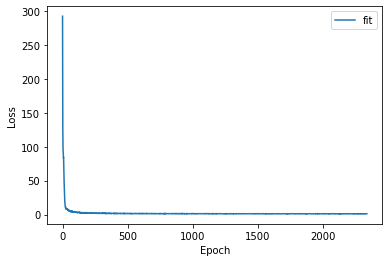

In [29]:
plt.plot(trainer.get_hist_metric('fit'), label='fit')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Customize your BP training

Actually, ``brainpy.train.BPTT`` is just one way to perform back-propagation training with your model. You can easily customize your training process.

In the below, we demonstrate how to define a BP training process by hand with the above ANN model.

In [30]:
# packages we need

from time import time

In [31]:
# define the model
model = ANNModel(28, 100, 10)

In [32]:
# define the loss function
@bm.to_object(child_objs=model)
def loss_fun(inputs, targets):
  runner = bp.train.DSTrainer(model, progress_bar=False, numpy_mon_after_run=False)
  predicts = runner.predict(inputs, reset_state=True)
  predicts = bm.max(predicts, axis=1)
  loss = bp.losses.cross_entropy_loss(predicts, targets)
  acc = bm.mean(predicts.argmax(-1) == targets)
  return loss, acc

In [33]:
# define the gradient function which computes the
# gradients of the trainable weights
grad_fun = bm.grad(loss_fun,
                   grad_vars=model.train_vars().unique(),
                   has_aux=True,
                   return_value=True)

In [34]:
# define the optimizer we need
opt = bp.optim.Adam(lr=1e-3, train_vars=model.train_vars().unique())

In [35]:
# training function

@bm.jit
@bm.to_object(child_objs=(opt, grad_fun))
def train(xs, ys):
  grads, loss, acc = grad_fun(xs, ys)
  opt.update(grads)
  return loss, acc

In [36]:
# start training

k = 0
num_batch = 256
running_loss = 0
running_acc = 0
print_step = 100
X_train = bm.asarray(x_train)
Y_train = bm.asarray(y_train)
t0 = time()
for _ in range(10):  # number of epoch
  X_train = bm.random.permutation(X_train, key=123)
  Y_train = bm.random.permutation(Y_train, key=123)

  for i in range(0, X_train.shape[0], num_batch):
    X = X_train[i: i + num_batch]
    Y = Y_train[i: i + num_batch]
    loss_, acc_ = train(X, Y)
    running_loss += loss_
    running_acc += acc_
    k += 1
    if k % print_step == 0:
      print('Step {}, Used {:.4f} s, Loss {:0.4f}, Acc {:0.4f}'.format(
        k, time() - t0,  running_loss / print_step, running_acc / print_step)
      )
      t0 = time()
      running_loss = 0
      running_acc = 0

Step 100, Used 6.9177 s, Loss 1.4299, Acc 0.5124
Step 200, Used 5.4387 s, Loss 0.6536, Acc 0.7700
Step 300, Used 6.6376 s, Loss 0.5670, Acc 0.7986
Step 400, Used 5.3037 s, Loss 0.5122, Acc 0.8166
Step 500, Used 5.3107 s, Loss 0.4720, Acc 0.8311
Step 600, Used 5.2464 s, Loss 0.4578, Acc 0.8336
Step 700, Used 5.2674 s, Loss 0.4350, Acc 0.8433
Step 800, Used 5.3320 s, Loss 0.4326, Acc 0.8424
Step 900, Used 5.2382 s, Loss 0.4015, Acc 0.8538
Step 1000, Used 5.3078 s, Loss 0.3973, Acc 0.8546
Step 1100, Used 5.2332 s, Loss 0.3939, Acc 0.8548
Step 1200, Used 5.3238 s, Loss 0.3802, Acc 0.8597
Step 1300, Used 5.2627 s, Loss 0.3709, Acc 0.8633
Step 1400, Used 5.3363 s, Loss 0.3779, Acc 0.8598
Step 1500, Used 5.3236 s, Loss 0.3615, Acc 0.8668
Step 1600, Used 5.2992 s, Loss 0.3586, Acc 0.8694
Step 1700, Used 5.3646 s, Loss 0.3581, Acc 0.8669
Step 1800, Used 5.2755 s, Loss 0.3442, Acc 0.8731
Step 1900, Used 5.3055 s, Loss 0.3443, Acc 0.8742
Step 2000, Used 5.2836 s, Loss 0.3465, Acc 0.8709
Step 2100